## How Does the Quantity of Rest Days Affect Player Performance for NBA Players?
In this program we will use 10 of the most popular players in the NBA, 2 from every position. The data collected is from all regular season games during the last 4 seasons.

In [23]:
# Load the dataset
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import numpy as np
import pandas as pd
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression


file_path = "/Users/alejandro/OneDrive/Documents/NBAStats.xlsx"

# Read the Excel file
df = pd.read_excel(file_path, engine='openpyxl')
df.dropna(inplace=True)



The bulk of this program will be to determine a numeric score that represents the "player performance"
## 1) Our first step is to normalize the data by dividing each of our 7 statistics by the mean for each statistic. 

In [24]:
df["IsWin"]=df["RESULT"].str.startswith("W")
df.replace({False: 0, True: 1}, inplace=True)
float_cols = ['MIN','PTS', 'REB', 'AST', 'STL', 'BLK', 'FG%', '3FG%']
df[float_cols]=df[float_cols].astype(float)
df=df[df['MIN'] >= 30]
df['Name'] = df['Name'].str.strip()

stats = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG%', '3FG%']

df[stats] = df[stats].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in any of the stats columns
df.dropna(subset=stats, inplace=True)
means = df[stats].mean()



# Normalize each stat and create new columns
for stat in stats:
    df[f'{stat}_norm'] = df[stat] / means[stat]
    
# Convert the 'DATE' column to strings
df['DATE'] = df['DATE'].astype(str)

# Remove the time part from the 'DATE' column
df['DATE'] = df['DATE'].str.split(' ').str[0]


# Display the DataFrame to verify the new columns
print(df.head())


            Name        DATE OPPONENT     RESULT   MIN   PTS  REB  AST  STL  \
1  Stephen Curry  2023-04-07    @SAC    W 119-97  33.0  25.0  7.0  6.0  2.0   
2  Stephen Curry  2023-04-04  vs OKC   W 136-125  37.0  34.0  5.0  6.0  1.0   
3  Stephen Curry  2023-04-02    @DEN   L 112-110  37.0  21.0  3.0  4.0  0.0   
4  Stephen Curry  2023-03-31   vs SA   W 130-115  33.0  33.0  2.0  5.0  0.0   
5  Stephen Curry  2023-03-28   vs NO   W 120-109  37.0  39.0  8.0  8.0  3.0   

   BLK   FG%  3FG%  IsWin  PTS_norm  REB_norm  AST_norm  STL_norm  BLK_norm  \
1  1.0  57.1  42.9      1  0.913660  0.879610  0.889572   1.87252   1.42545   
2  0.0  44.0  46.2      1  1.242577  0.628293  0.889572   0.93626   0.00000   
3  2.0  28.6  14.3      0  0.767474  0.376976  0.593048   0.00000   2.85090   
4  0.0  52.4  63.6      1  1.206031  0.251317  0.741310   0.00000   0.00000   
5  0.0  56.0  53.3      1  1.425309  1.005269  1.186096   2.80878   0.00000   

   FG%_norm  3FG%_norm  
1  1.145362   1.248325  


## 2) Then, we will use a Decision Tree classifier to compute how important each statistic is towards a player winning a game.

It is important to know that our player performance is evaluated in respect to winning games, since this is the fundamental goal for any player or coach in the NBA. 

Random Forest Accuracy for Stephen Curry: 0.6379310344827587
Random Forest Accuracy for Trae Young: 0.6
Random Forest Accuracy for Devin Booker: 0.7017543859649122
Random Forest Accuracy for James Harden: 0.6851851851851852
Random Forest Accuracy for Lebron James: 0.6274509803921569
Random Forest Accuracy for Kevin Durant: 0.5102040816326531
Random Forest Accuracy for Jason Tatum: 0.5909090909090909
Random Forest Accuracy for Giannis Antetokoumpo: 0.6226415094339622
Random Forest Accuracy for Domantas Sabonis: 0.59375
Random Forest Accuracy for Joel Embiid: 0.6382978723404256


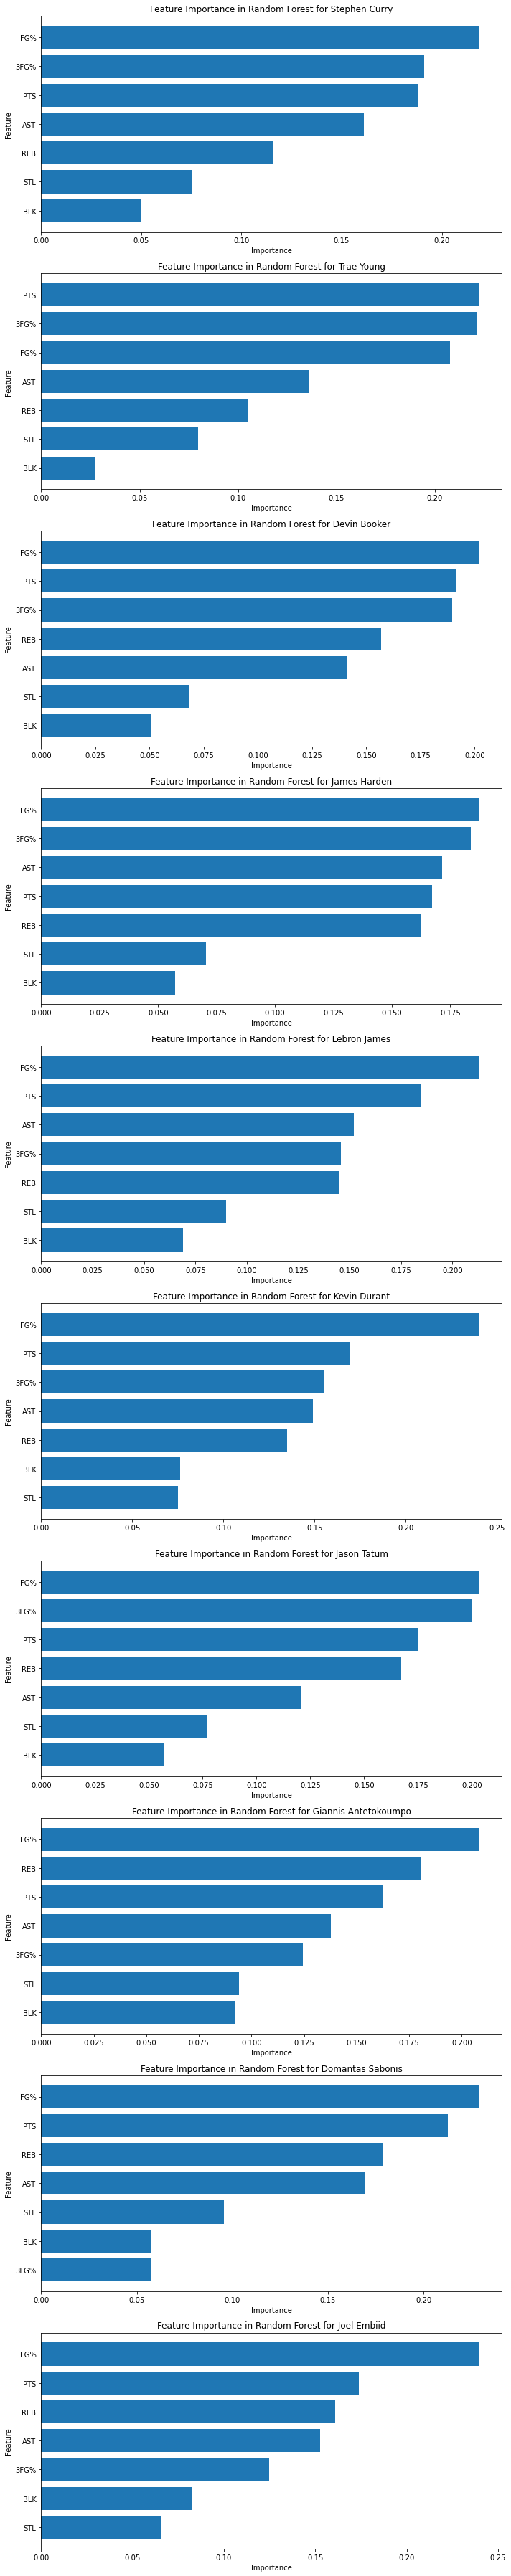

In [25]:
stats = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG%', '3FG%']


# Prepare a DataFrame to store feature importances and weights for each player
player_importances = pd.DataFrame()

# List of features (normalized stats)
features = [f'{stat}' for stat in stats]

# Loop through each player and calculate feature importances
for player in df['Name'].unique():
    player_df = df[df['Name'] == player]
    
    X = player_df[features]
    y = player_df['IsWin']
    
    # Ensure target is aligned with the filtered features
    y = y[X.index]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy for {player}: {accuracy}")
    
    # Extract feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Calculate weights
    
    # Add player name to the DataFrame
    feature_importance['Player'] = player
    feature_importance.head(70)
    # Append to the overall DataFrame
    player_importances = pd.concat([player_importances, feature_importance], axis=0)
    
players = df['Name'].unique()
fig, axes = plt.subplots(len(players), 1, figsize=(10, len(players) * 5))

for i, player in enumerate(players):
    player_data = player_importances[player_importances['Player'] == player]
    ax = axes[i]
    ax.barh(player_data['Feature'], player_data['Importance'])
    ax.set_title(f'Feature Importance in Random Forest for {player}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    ax.invert_yaxis()  # Most important feature at the top

plt.tight_layout()
plt.show()

## 3) Now we multiply the normalized statistics for each player by the weighted importance of that stat and sum this number to obtain our score. 

In [26]:
norm_features=['PTS_norm', 'REB_norm', 'AST_norm', 'STL_norm', 'BLK_norm', 'FG%_norm', '3FG%_norm']
for player in df['Name'].unique():
    player_df = df[df['Name'] == player]
    weights = player_importances[player_importances['Player'] == player]['Importance'].values
    weighted_stats = player_df[norm_features].mul(weights, axis=1)
    df.loc[df['Name'] == player, 'PerformanceScore'] = weighted_stats.sum(axis=1)

# Display the DataFrame with performance scores
df_Name_DATE_PerformanceScore=df[['Name', 'DATE', 'PerformanceScore']]
df_Name_DATE_PerformanceScore.head()
df.head()

,Name,DATE,OPPONENT,RESULT,MIN,PTS,REB,AST,STL,BLK,...,3FG%,IsWin,PTS_norm,REB_norm,AST_norm,STL_norm,BLK_norm,FG%_norm,3FG%_norm,PerformanceScore
1,Stephen Curry,2023-04-07,@SAC,W 119-97,33.0,25.0,7.0,6.0,2.0,1.0,...,42.9,1,0.913660,0.879610,0.889572,1.87252,1.42545,1.145362,1.248325,1.150334
2,Stephen Curry,2023-04-04,vs OKC,W 136-125,37.0,34.0,5.0,6.0,1.0,0.0,...,46.2,1,1.242577,0.628293,0.889572,0.93626,0.00000,0.882590,1.344350,0.843722
3,Stephen Curry,2023-04-02,@DEN,L 112-110,37.0,21.0,3.0,4.0,0.0,2.0,...,14.3,0,0.767474,0.376976,0.593048,0.00000,2.85090,0.573684,0.416108,0.744717
4,Stephen Curry,2023-03-31,vs SA,W 130-115,33.0,33.0,2.0,5.0,0.0,0.0,...,63.6,1,1.206031,0.251317,0.741310,0.00000,0.00000,1.051085,1.850664,0.622602
5,Stephen Curry,2023-03-28,vs NO,W 120-109,37.0,39.0,8.0,8.0,3.0,0.0,...,53.3,1,1.425309,1.005269,1.186096,2.80878,0.00000,1.123297,1.550949,1.341874


Below we see the correlation between the performance score and win/loss. The low correlation is a result that these players are all stars on their team, who frequently perform well but don't always get a win as a result of their other teamates. 

In [27]:
player_correlations = []

for player in df['Name'].unique():
    player_df = df[df['Name'] == player]
    
    # Calculate the correlation
    correlation = player_df['PerformanceScore'].corr(player_df['IsWin'])
    correlation_rounded = round(correlation, 3)
    #print(f"Correlation between PerformanceScore and IsWin for {player}: {correlation_rounded}")
    
    # Store the correlation for each player
    player_correlations.append((player, correlation))

# Convert the results to a DataFrame for easy viewing
correlation_df = pd.DataFrame(player_correlations, columns=['Player', 'Correlation'])

# Display the correlations
print(correlation_df)

#columns_to_drop = ['PTS_norm', 'REB_norm', 'AST_norm', 'STL_norm', 'BLK_norm', 'FG%_norm', '3FG%_norm']

# Drop the  normalized columns from the DataFrame
#df.drop(columns=columns_to_drop, inplace=True)

                 Player  Correlation
0         Stephen Curry     0.193298
1            Trae Young     0.175450
2          Devin Booker     0.060063
3          James Harden     0.226856
4          Lebron James     0.113626
5          Kevin Durant     0.023215
6           Jason Tatum     0.160346
7  Giannis Antetokoumpo     0.181369
8      Domantas Sabonis     0.173404
9           Joel Embiid     0.176410


## 5) When evaluating performance, it is crucial to note the difficulty of the opponent. Therefore, for each season I collected data and ranked them based on the amount of wins they had that season. 

In [28]:
ranked_teams_24 = {
    'BOS': 1,   # Boston Celtics
    'OKC': 2,   # Oklahoma City Thunder
    'DEN': 3,   # Denver Nuggets
    'MIN': 4,   # Minnesota Timberwolves
    'LAC': 5,   # Los Angeles Clippers
    'NY': 6,    # New York Knicks
    'DAL': 7,   # Dallas Mavericks
    'MIL': 8,   # Milwaukee Bucks
    'PHO': 9,   # Phoenix Suns
    'NOP': 10,  # New Orleans Pelicans
    'CLE': 11,  # Cleveland Cavaliers
    'ORL': 12,  # Orlando Magic
    'IND': 13,  # Indiana Pacers
    'PHI': 14,  # Philadelphia 76ers
    'LAL': 15,  # Los Angeles Lakers
    'MIA': 16,  # Miami Heat
    'SAC': 17,  # Sacramento Kings
    'GS': 18,   # Golden State Warriors
    'HOU': 19,  # Houston Rockets
    'CHI': 20,  # Chicago Bulls
    'ATL': 21,  # Atlanta Hawks
    'BKN': 22,  # Brooklyn Nets
    'UTA': 23,  # Utah Jazz
    'MEM': 24,  # Memphis Grizzlies
    'TOR': 25,  # Toronto Raptors
    'SA': 26,  # San Antonio Spurs
    'CHA': 27,  # Charlotte Hornets
    'POR': 28,  # Portland Trail Blazers
    'WAS': 29,  # Washington Wizards
    'DET': 30   # Detroit Pistons
}
ranked_teams_23 = {
    'MIL': 1,   # Bucks
    'BOS': 2,   # Celtics
    'PHI': 3,   # 76ers
    'DEN': 4,   # Nuggets
    'CLE': 5,   # Cavaliers
    'MEM': 6,   # Grizzlies
    'SAC': 7,   # Kings
    'NY': 8,    # Knicks
    'PHO': 9,   # Suns
    'LAC': 10,  # Clippers
    'GS': 11,   # Warriors
    'MIA': 12,  # Heat
    'LAL': 13,  # Lakers
    'MIN': 14,  # Timberwolves
    'NO': 15,  # Pelicans
    'BKN': 16,  # Nets
    'ATL': 17,  # Hawks
    'TOR': 18,  # Raptors
    'CHI': 19,  # Bulls
    'OKC': 20,  # Thunder
    'DAL': 21,  # Mavericks
    'UTA': 22,  # Jazz
    'IND': 23,  # Pacers
    'WAS': 24,  # Wizards
    'ORL': 25,  # Magic
    'CHA': 26,  # Hornets
    'POR': 27,  # Trail Blazers
    'HOU': 28,  # Rockets
    'SA': 29,  # Spurs
    'DET': 30   # Pistons
}
ranked_teams_22   = {
    'PHO': 1,   # Suns
    'MEM': 2,   # Grizzlies
    'MIA': 3,   # Heat
    'GS': 4,    # Warriors
    'BOS': 5,   # Celtics
    'MIL': 6,   # Bucks
    'PHI': 7,   # 76ers
    'DAL': 8,   # Mavericks
    'UTA': 9,   # Jazz
    'TOR': 10,  # Raptors
    'DEN': 11,  # Nuggets
    'CHI': 12,  # Bulls
    'MIN': 13,  # Timberwolves
    'BKN': 14,  # Nets
    'CLE': 15,  # Cavaliers
    'ATL': 16,  # Hawks
    'CHA': 17,  # Hornets
    'NO': 18,   # Pelicans
    'LAC': 19,  # Clippers
    'NY': 20,   # Knicks
    'SAS': 21,  # Spurs
    'WAS': 22,  # Wizards
    'LAL': 23,  # Lakers
    'SAC': 24,  # Kings
    'POR': 25,  # Trail Blazers
    'IND': 26,  # Pacers
    'OKC': 27,  # Thunder
    'DET': 28,  # Pistons
    'HOU': 29,  # Rockets
    'ORL': 30   # Magic
}
ranked_teams_21 = {
    'UTA': 1,    # Jazz
    'PHO': 2,    # Suns
    'PHI': 3,    # 76ers
    'BKN': 4,    # Nets
    'DEN': 5,    # Nuggets
    'LAC': 6,    # Clippers
    'MIL': 7,    # Bucks
    'NY': 8,     # Knicks
    'DAL': 9,    # Mavericks
    'POR': 10,   # Trail Blazers
    'LAL': 11,   # Lakers
    'ATL': 12,   # Hawks
    'MIA': 13,   # Heat
    'MEM': 14,   # Grizzlies
    'GS': 15,    # Warriors
    'BOS': 16,   # Celtics
    'WAS': 17,   # Wizards
    'SAS': 18,   # Spurs
    'IND': 19,   # Pacers
    'CHA': 20,   # Hornets
    'NO': 21,    # Pelicans
    'CHI': 22,   # Bulls
    'TOR': 23,   # Raptors
    'SAC': 24,   # Kings
    'MIN': 25,   # Timberwolves
    'OKC': 26,   # Thunder
    'CLE': 27,   # Cavaliers
    'ORL': 28,   # Magic
    'HOU': 29,   # Rockets
    'DET': 30    # Pistons
}
df['OPPONENT'] = df['OPPONENT'].str.replace('@', '', regex=False)
df['OPPONENT'] = df['OPPONENT'].str.replace('vs ', '', regex=False)
df['OPPONENT'] = df['OPPONENT'].astype(str)
df['OPPONENT'] = df['OPPONENT'].str.strip()
## converts the Opponent column to just an Abbriviation and a string type
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df.sort_values(by=['Name', 'DATE'], inplace=True)

## Sets the date to datetime values
# Filter games before June 2022
before_jun_2022 = df[df['DATE'] < '2022-06-01']

# Filter games before June 2023
before_jun_2023 = df[df['DATE'] < '2023-06-01']

# Filter games before June 2024
before_jun_2024 = df[df['DATE'] < '2024-06-01']
# Define the date ranges for each season
date_ranges = {
    '2021': (pd.to_datetime('2020-07-01'), pd.to_datetime('2021-06-30')),
    '2022': (pd.to_datetime('2021-07-01'), pd.to_datetime('2022-06-30')),
    '2023': (pd.to_datetime('2022-07-01'), pd.to_datetime('2023-06-30')),
    '2024': (pd.to_datetime('2023-07-01'), pd.to_datetime('2024-06-30'))
}

# Function to map the opponent rank based on the date
def get_opponent_rank(row):
    if date_ranges['2021'][0] <= row['DATE'] <= date_ranges['2021'][1]:
        return ranked_teams_21.get(row['OPPONENT'])
    elif date_ranges['2022'][0] <= row['DATE'] <= date_ranges['2022'][1]:
        return ranked_teams_22.get(row['OPPONENT'])
    elif date_ranges['2023'][0] <= row['DATE'] <= date_ranges['2023'][1]:
        return ranked_teams_23.get(row['OPPONENT'])
    elif date_ranges['2024'][0] <= row['DATE'] <= date_ranges['2024'][1]:
        return ranked_teams_24.get(row['OPPONENT'])
    
    else:
        return None

df['OPPONENT_RANK'] = df.apply(get_opponent_rank, axis=1)


## 5) (Continued) To implement the opponent difficult to performance score, I multiplied each score by a factor based on the team ranking. I splitted the performance score into 3 groups: the best, middle, and worst ten teams. Players performed 

In [29]:
## Calculating the win percentage and avg player performance for each player against the better 15 teams
## and worse 15 teams.
best_teams_df = df[df['OPPONENT_RANK'] <= 10]
#
middle_teams_df = df[(df['OPPONENT_RANK'] >= 11) & (df['OPPONENT_RANK'] <= 20)]
# Filter for worst teams (ranked 16-30)
worst_teams_df = df[df['OPPONENT_RANK'] > 20]

# Function to calculate metrics
def calculate_metrics(df):
    metrics = df.groupby('Name').agg(
        win_percentage=('IsWin', 'mean'),
        avg_performance_score=('PerformanceScore', 'mean')
    ).reset_index()
    metrics['win_percentage'] *= 100  # Convert to percentage
    return metrics

# Calculate metrics for best and worst teams
best_teams_metrics = calculate_metrics(best_teams_df)
middle_teams_metrics = calculate_metrics(middle_teams_df)
worst_teams_metrics = calculate_metrics(worst_teams_df)

best_mean=best_teams_metrics['avg_performance_score'].mean()
middle_mean=middle_teams_metrics['avg_performance_score'].mean()
worst_mean=worst_teams_metrics['avg_performance_score'].mean()
print("The performance score was ",round(100*(worst_mean/best_mean-1),3),"% better for players playing against the worst teams compared to the best teams")

The performance score was  6.498 % better for players playing against the worst teams compared to the best teams


## 6) To balance the scores so that the performance score is on avarage the same amongst all teams (which takes into consideration the team rating of each team) we adjust each score by an optimized factor based on the team rating. 

In [30]:
## Calculating the win percentage and avg player performance for each player against the better 15 teams
## and worse 15 teams.
# Apply the function to create the 'OPPONENT_RANK' column
df['OPPONENT_RANK'] = df.apply(get_opponent_rank, axis=1)
df['balanced_player_performance'] = df['PerformanceScore'] * (1 + (30 - df['OPPONENT_RANK']) / 334)


best_teams_df = df[df['OPPONENT_RANK'] <= 10]
#
middle_teams_df = df[(df['OPPONENT_RANK'] >= 11) & (df['OPPONENT_RANK'] <= 20)]
# Filter for worst teams (ranked 16-30)
worst_teams_df = df[df['OPPONENT_RANK'] > 20]

# Function to calculate metrics
def calculate_metrics(df):
    metrics = df.groupby('Name').agg(
        win_percentage=('IsWin', 'mean'),
        avg_performance_score=('balanced_player_performance', 'mean')
    ).reset_index()
    metrics['win_percentage'] *= 100  # Convert to percentage
    return metrics

# Calculate metrics for best and worst teams
best_teams_metrics = calculate_metrics(best_teams_df)
middle_teams_metrics = calculate_metrics(middle_teams_df)
worst_teams_metrics = calculate_metrics(worst_teams_df)

# Display the metrics
print("Metrics against best 10 teams:")
print(best_teams_metrics)
print("Metrics against middle 10 teams:")
print(middle_teams_metrics)
print("\nMetrics against worst 10 teams:")
print(worst_teams_metrics)

Metrics against best 10 teams:
                   Name  win_percentage  avg_performance_score
0          Devin Booker       60.606061               0.787877
1      Domantas Sabonis       38.888889               1.088833
2  Giannis Antetokoumpo       60.606061               1.247690
3          James Harden       48.333333               1.051725
4           Jason Tatum       53.750000               0.997611
5           Joel Embiid       53.571429               1.277123
6          Kevin Durant       47.540984               1.129586
7          Lebron James       42.028986               1.145279
8         Stephen Curry       46.428571               0.866593
9            Trae Young       36.111111               0.924277
Metrics against middle 10 teams:
                   Name  win_percentage  avg_performance_score
0          Devin Booker       70.129870               0.868464
1      Domantas Sabonis       42.857143               1.108920
2  Giannis Antetokoumpo       62.962963               

In [31]:
#best_vs_worst_diff = (best_teams_metrics['avg_performance_score'] - worst_teams_metrics['avg_performance_score']).abs().sum()
#best_vs_middle_diff = (best_teams_metrics['avg_performance_score'] - middle_teams_metrics['avg_performance_score']).abs().sum()
#middle_vs_worst_diff = (middle_teams_metrics['avg_performance_score'] - worst_teams_metrics['avg_performance_score']).abs().sum()


# Display the results
#print("Difference between best and worst teams:", best_vs_worst_diff)
#print("Difference between best and middle teams:", best_vs_middle_diff)
#print("Difference between middle and worst teams:", middle_vs_worst_diff)
#print("Difference:", best_vs_worst_diff+best_vs_middle_diff+middle_vs_worst_diff)

best_mean=best_teams_metrics['avg_performance_score'].mean()
middle_mean=middle_teams_metrics['avg_performance_score'].mean()
worst_mean=worst_teams_metrics['avg_performance_score'].mean()
print("The performance score was ",round(100*(worst_mean/best_mean-1),3),"% better for players playing against the worst teams compared to the best teams")

The performance score was  0.513 % better for players playing against the worst teams compared to the best teams


The scores are now barely different, so we have succesfully taken into account the opponent quality

## 7) Our original question can now be answered with our accurate and balanced performance scores. I procede to calcualte the rest days between each game and set any gap of more than 7 day rest to 7 days.  Due to the significant amount of rest_days=2, we have randomly shrunk this in half to eliminate possible majority bias. 

In [32]:

##Difference of days between games
df['DaysSinceLastGame'] = df.groupby('Name')['DATE'].diff().dt.days

# Fill NaN values (first game) with 7 days
df['DaysSinceLastGame'].fillna(7, inplace=True)

# Cap any differences greater than 7 days to 7 days
df['DaysSinceLastGame'] = df['DaysSinceLastGame'].apply(lambda x: min(x, 7))


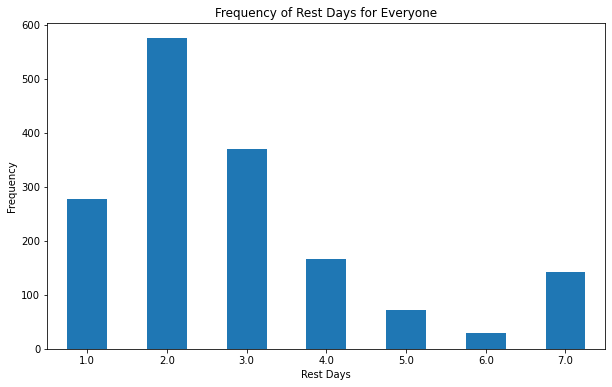

In [34]:
two_days_rest_df = df[df['DaysSinceLastGame'] == 2]

# Randomly select half of these rows
random_half = two_days_rest_df.sample(frac=0.5, random_state=42)

# Remove these selected rows from the original DataFrame
df = df.drop(random_half.index)

curry_df = df[df['Name'] == 'James Harden']

# Count the frequency of each rest day value
rest_days_counts = curry_df['DaysSinceLastGame'].value_counts().sort_index()
rest_days_totals=df['DaysSinceLastGame'].value_counts().sort_index()
# Plot the bar graph
plt.figure(figsize=(10, 6))
rest_days_totals.plot(kind='bar')
plt.xlabel('Rest Days')
plt.ylabel('Frequency')
plt.title('Frequency of Rest Days for Everyone')
plt.xticks(rotation=0)
plt.show()


In [35]:
rest_days_stats = df.groupby('DaysSinceLastGame')['balanced_player_performance'].agg(['mean']).reset_index()

# Display the results
print(rest_days_stats)

   DaysSinceLastGame      mean
0                1.0  1.020958
1                2.0  1.018855
2                3.0  1.057780
3                4.0  1.081916
4                5.0  1.138504
5                6.0  1.068978
6                7.0  1.050000


Above we see the avarage performance score for each amount of rest days for all the players

In [85]:
median_performance = df.groupby(['Name', 'DaysSinceLastGame'])['balanced_player_performance'].median().reset_index()
pd.set_option('display.max_rows', None)


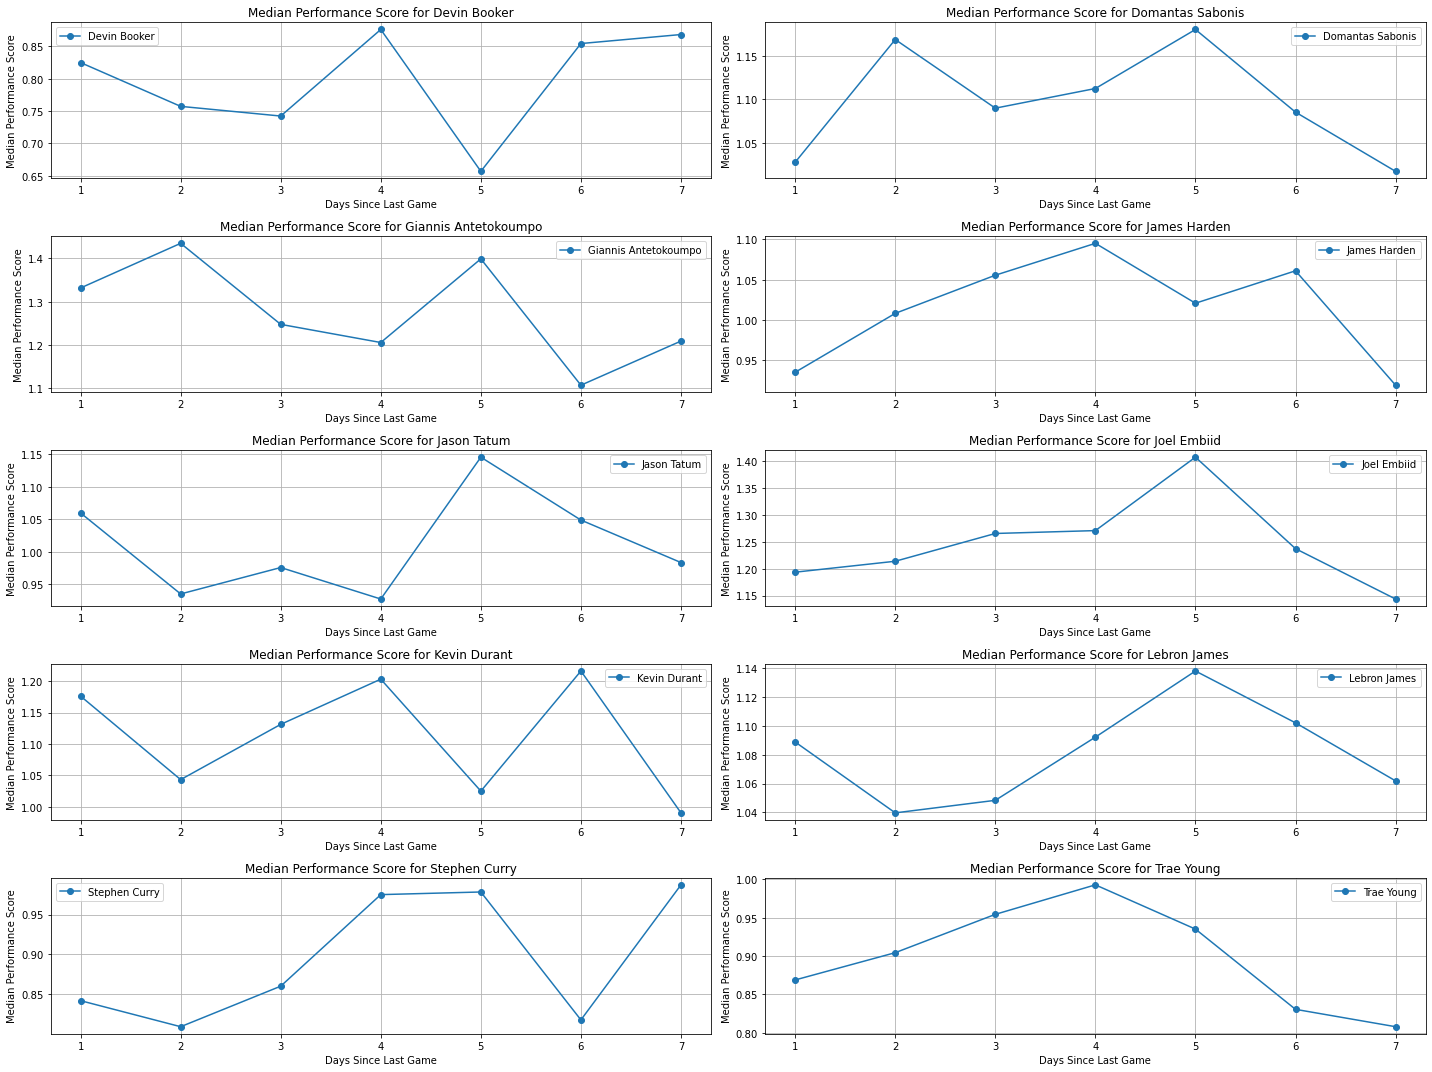

In [86]:
players = median_performance['Name'].unique()

# Create a line chart for each player
plt.figure(figsize=(20, 15))
for i, player in enumerate(players, 1):
    plt.subplot(5, 2, i)
    player_data = median_performance[median_performance['Name'] == player]
    plt.plot(player_data['DaysSinceLastGame'], player_data['balanced_player_performance'], marker='o', linestyle='-', label=player)
    plt.title(f'Median Performance Score for {player}')
    plt.xlabel('Days Since Last Game')
    plt.ylabel('Median Performance Score')
    plt.xticks(range(1, 8))
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## 8 out of our 10 players have their peak performance at either 4 or 5 days of rest. The other 2 players, Giannis and Durant, have their 2nd highest performance during those days as well. 

## 8 out of our 10 players have a decrease in performance towards the 6,7 day rest mark, probably due to a loss of game rythm or a return from injury

## Valuable Insights
* Rather than a one-size-fits-all approach, creating individual rest plans for players would benefit each players performance. 
* Implement player rotations and focus on getting the optimal amount of rest days for the star players. 
* Aiming for 4-5 rest days is particularly useful during long stretches of the season or before important games to maximize player performance.
* Establish caution with players returning from injury, as extended rest might not be beneficial for their performance. Gradual integration with optimal rest days can help in better performance recovery.